Код снизу плохо структурирован, не завернут в функции и вглядит плохо, поскольку выполнялся в разных файлах.

Схема поиска оптимальной модели имеет следующий вид:
1) Выброс пропуской, дубликатов, сплит, работа с выбросами(реализовывалась опционально через 3 стандартных отклонения), gridsearchcv на поиск оптимальных параметров, изучение результатов(тестовая выборка, confusion matrix, thresholds), для некоторых моделей дальнейший подбор параметров(проверка гиперпараметров лучших моделей в решетке на скор на различных сплитах, отклонение от среднего значения, работа с фичами). В качестве метрики был выбрал precision(на что указывает заинтересованность в отборе именно качественного вина)

Были опробованы следующие модели: KNeighbors, SVC, LogisticRegression.
Для KNeighbors и SVC было проведено дальнейшее исследование(с выбросом фичей, построением полиномов, проверка "устойчивости модели на разных сплитах").
Обычные линейные модели рассмотрены не были из-за своей простоты.
LogisticRegression не была подробно исследована, поскольку на этапе gridsearchcv показала нестабильный и низкий результат.

Лучшей моделью по итогу оказался алгоритм KNeighbors(n_neighbors=30, p=4, weights='distance') c MinMaxScaler в качестве скейлера, были дропнуты следующие фичи: 'citric acid', 'alcohol', 'total sulfur dioxide'.
'citric acid' была исключена, посколку имеет ненормальное распределение из-за чего будет смещать модель, остальные были исключены из-за корреляции с другими фичами. Также их исключение положительно сказывалось на среднем скоре и отклонении скора.
Выбросы оставлены(значения более 3 std), без полиномов, поскольку это ухудшало модель на тесте.

### Область работы 1 (библиотеки)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from scipy import stats
import statistics

from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    ShuffleSplit, KFold

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, \
                                  RobustScaler, PolynomialFeatures

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, \
                            f1_score, ConfusionMatrixDisplay, \
                            confusion_matrix, roc_auc_score, \
                            RocCurveDisplay, PrecisionRecallDisplay, \
                            roc_curve, precision_recall_curve, \
                            PrecisionRecallDisplay

### Область работы 2 (поиск  модели .... )

In [4]:
path_train = 'train.csv'

In [5]:
data = pd.read_csv(path_train)
data.head(10)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            5.0             0.740         0.00            1.20      0.041   
1           11.0             0.260         0.68            2.55      0.085   
2            7.3             0.380         0.21            2.00      0.080   
3            8.9             0.280         0.45            1.70      0.067   
4            9.2             0.410         0.50            2.50      0.055   
5            6.8             0.470         0.08            2.20      0.064   
6            7.8             0.550         0.35            2.20      0.074   
7            7.6             0.735         0.02            2.50      0.071   
8            7.3             0.340         0.33            2.50      0.064   
9            5.4             0.740         0.00            1.20      0.041   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 16.0                  46.0  0.99258  4.01       0.59   
1                 10.0                  25.0  0.99700  3.18       0.61   
2                  7.0                  35.0  0.99610  3.33       0.47   
3                  7.0                  12.0  0.99354  3.25       0.55   
4                 12.0                  25.0  0.99520  3.34       0.79   
5                 18.0                  38.0  0.99553  3.30       0.65   
6                 21.0                  66.0  0.99740  3.25       0.56   
7                 10.0                  14.0  0.99538  3.51       0.71   
8                 21.0                  37.0  0.99520  3.35       0.77   
9                 16.0                  46.0  0.99258  4.01       0.59   

   alcohol  quality  
0     12.5        6  
1     11.8        5  
2      9.5        5  
3     12.3        7  
4     13.3        7  
5      9.6        6  
6      9.2        5  
7     11.7        7  
8     12.1        7  
9     12.5        6

In [6]:
display(data.info())
display(data.describe())
display(data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1294 non-null   float64
 1   volatile acidity      1294 non-null   float64
 2   citric acid           1295 non-null   float64
 3   residual sugar        1295 non-null   float64
 4   chlorides             1295 non-null   float64
 5   free sulfur dioxide   1295 non-null   float64
 6   total sulfur dioxide  1295 non-null   float64
 7   density               1295 non-null   float64
 8   pH                    1294 non-null   float64
 9   sulphates             1293 non-null   float64
 10  alcohol               1295 non-null   float64
 11  quality               1295 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 121.5 KB


None

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1294.000000       1294.000000  1295.000000     1295.000000   
mean        8.438872          0.500920     0.298880        2.573398   
std         1.818823          0.182181     0.200443        1.366700   
min         4.700000          0.120000     0.000000        0.900000   
25%         7.200000          0.360000     0.120000        1.900000   
50%         8.100000          0.480000     0.310000        2.200000   
75%         9.400000          0.620000     0.455000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1295.000000          1295.000000           1295.000000  1295.000000   
mean      0.085467            15.362934             44.651351     0.996576   
std       0.045056            10.487662             35.420622     0.001968   
min       0.012000             1.000000              7.000000     0.990070   
25%       0.068000             7.000000             20.000000     0.995315   
50%       0.078000            13.000000             34.000000     0.996600   
75%       0.090000            21.000000             57.000000     0.997765   
max       0.611000            72.000000            289.000000     1.003200   

                pH    sulphates      alcohol      quality  
count  1294.000000  1293.000000  1295.000000  1295.000000  
mean      3.303648     0.678415    10.676100     5.937452  
std       0.157238     0.169927     1.174136     0.955717  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.200000     0.570000     9.600000     5.000000  
50%       3.300000     0.640000    10.500000     6.000000  
75%       3.390000     0.760000    11.500000     7.000000  
max       4.010000     2.000000    14.900000     8.000000

fixed acidity           1
volatile acidity        1
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      1
sulphates               2
alcohol                 0
quality                 0
dtype: int64

In [7]:
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
display(only_na)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
637             6.4             0.530         0.09             3.9      0.123   
698             5.9             0.550         0.10             2.2      0.062   
720             NaN             0.705         0.10             2.8      0.081   
1146            7.2               NaN         0.33             2.5      0.068   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
637                  14.0                  31.0  0.99680  3.50        NaN   
698                  39.0                  51.0  0.99512  3.52        NaN   
720                  13.0                  28.0  0.99631   NaN       0.66   
1146                 34.0                 102.0  0.99414  3.27       0.78   

      alcohol  quality  
637      11.0        4  
698      11.2        6  
720      10.2        5  
1146     12.8        6

In [8]:
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
display(data_no_na.head(3))
display(data_no_na.wine_class.value_counts())

C:\Users\Arseny\AppData\Local\Temp\ipykernel_19788\3372638768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            5.0              0.74         0.00            1.20      0.041   
1           11.0              0.26         0.68            2.55      0.085   
2            7.3              0.38         0.21            2.00      0.080   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 16.0                  46.0  0.99258  4.01       0.59   
1                 10.0                  25.0  0.99700  3.18       0.61   
2                  7.0                  35.0  0.99610  3.33       0.47   

   alcohol  quality  wine_class  
0     12.5        6           0  
1     11.8        5           0  
2      9.5        5           0

wine_class
0    877
1    414
Name: count, dtype: int64

In [9]:
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
display(no_duplicates.shape)

(1015, 13)

In [10]:
display(only_duplicates.shape)
display(no_duplicates.isna().sum())

(276, 13)

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine_class              0
dtype: int64

In [11]:
train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3, stratify=pd.DataFrame(no_duplicates.quality), shuffle=True)
display(train_data.shape)
del train_target

(710, 12)

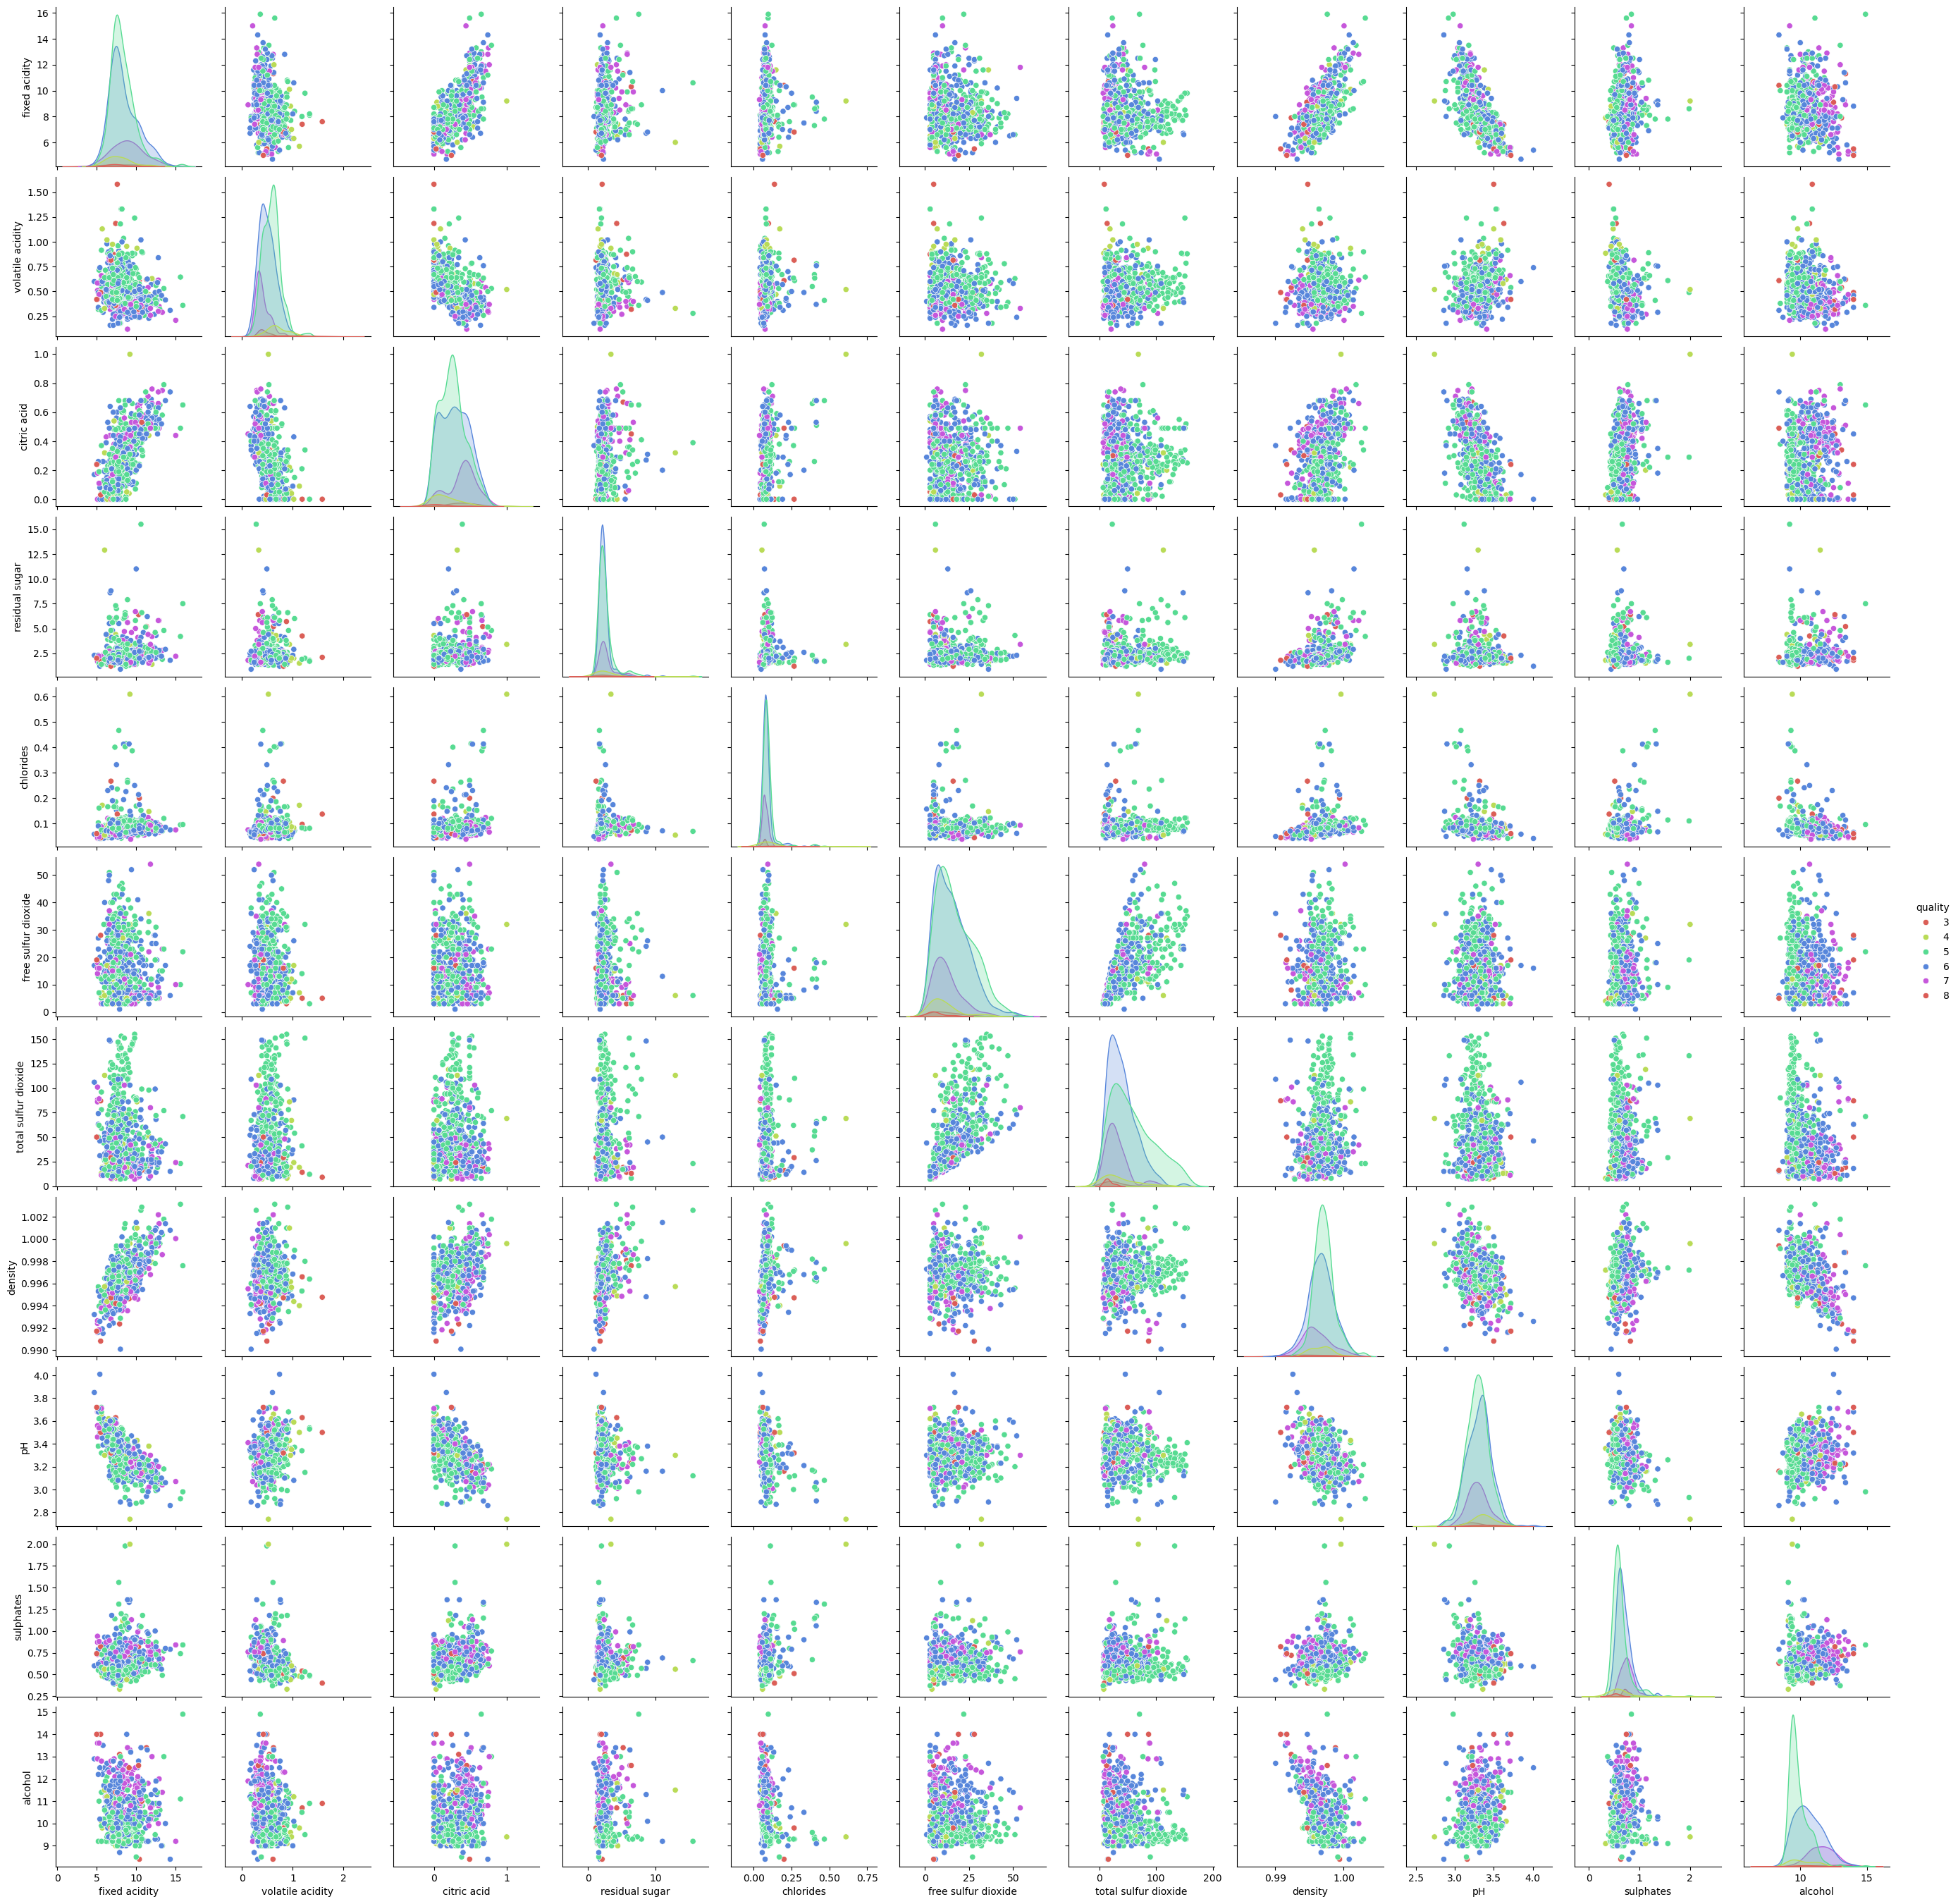

In [12]:
sns.pairplot(train_data, hue='quality', palette='hls')

In [13]:
train_data.head(3)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
332            7.4              0.36         0.29             2.6      0.087   
522            5.7              1.13         0.09             1.5      0.172   
401           11.9              0.57         0.50             2.6      0.082   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
332                 26.0                  72.0  0.99645  3.39       0.68   
522                  7.0                  19.0  0.99400  3.50       0.48   
401                  6.0                  32.0  1.00060  3.12       0.78   

     alcohol  quality  
332     11.0        5  
522      9.8        4  
401     10.7        6

In [14]:
z = stats.zscore(train_data)
display(z.head(10))
train_data_clean = train_data.drop(axis=1, columns=['citric acid'])[~(np.abs(z) > 3).any(axis=1)]
#.drop(axis=1, columns=['citric acid'])
train_data_clean.head(3)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
332      -0.572522         -0.896299     0.046084        0.074244  -0.035272   
522      -1.551325          3.223826    -0.986080       -0.806976   1.728348   
401       2.018425          0.227372     1.129856        0.074244  -0.139015   
198      -0.342216          2.046648    -1.089297       -0.486532  -0.636978   
839      -0.802829         -0.896299    -0.366782       -0.085978  -0.056021   
604      -0.514946          0.601929    -1.450554       -0.085978  -0.242757   
952       1.788119         -0.575250     1.026640        0.074244  -0.242757   
261       3.400263         -1.163839     2.368453       -0.566643  -0.284254   
730      -0.860405          0.575175    -0.573215       -0.085978   3.159994   
495       0.406280         -1.217347     0.304125       -0.406422  -0.512487   

     free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
332             1.052897              0.767874 -0.168427  0.579594   0.116530   
522            -0.863657             -0.841836 -1.514220  1.310993  -1.061208   
401            -0.964528             -0.447001  2.111181 -1.215658   0.705399   
198             0.649412              0.008577 -0.827591  1.377484  -1.355643   
839             0.851155              0.676758 -0.657307  0.646085  -0.766774   
604             0.245927             -0.538117 -0.140962  0.114158  -0.354565   
952            -0.762786             -0.811464  0.968631 -1.415131  -0.766774   
261            -0.964528             -0.963323  2.221042 -2.944419   0.764285   
730            -0.964528             -0.872208 -0.360683  0.646085  -0.413452   
495            -0.359301             -0.659604 -0.877028 -0.284787   1.058720   

      alcohol   quality  
332  0.512963 -0.762200  
522 -0.573536 -1.978294  
401  0.241338  0.453894  
198  0.241338  0.453894  
839 -0.301911  0.453894  
604 -0.392453  0.453894  
952  0.512963 -0.762200  
261 -1.841118  0.453894  
730 -0.120828  0.453894  
495  1.146754  1.669988

fixed acidity  volatile acidity  residual sugar  chlorides  \
332            7.4              0.36             2.6      0.087   
401           11.9              0.57             2.6      0.082   
198            7.8              0.91             1.9      0.058   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
332                 26.0                  72.0  0.99645  3.39       0.68   
401                  6.0                  32.0  1.00060  3.12       0.78   
198                 22.0                  47.0  0.99525  3.51       0.43   

     alcohol  quality  
332     11.0        5  
401     10.7        6  
198     10.7        6

In [15]:
train_data_clean.shape[0]

641

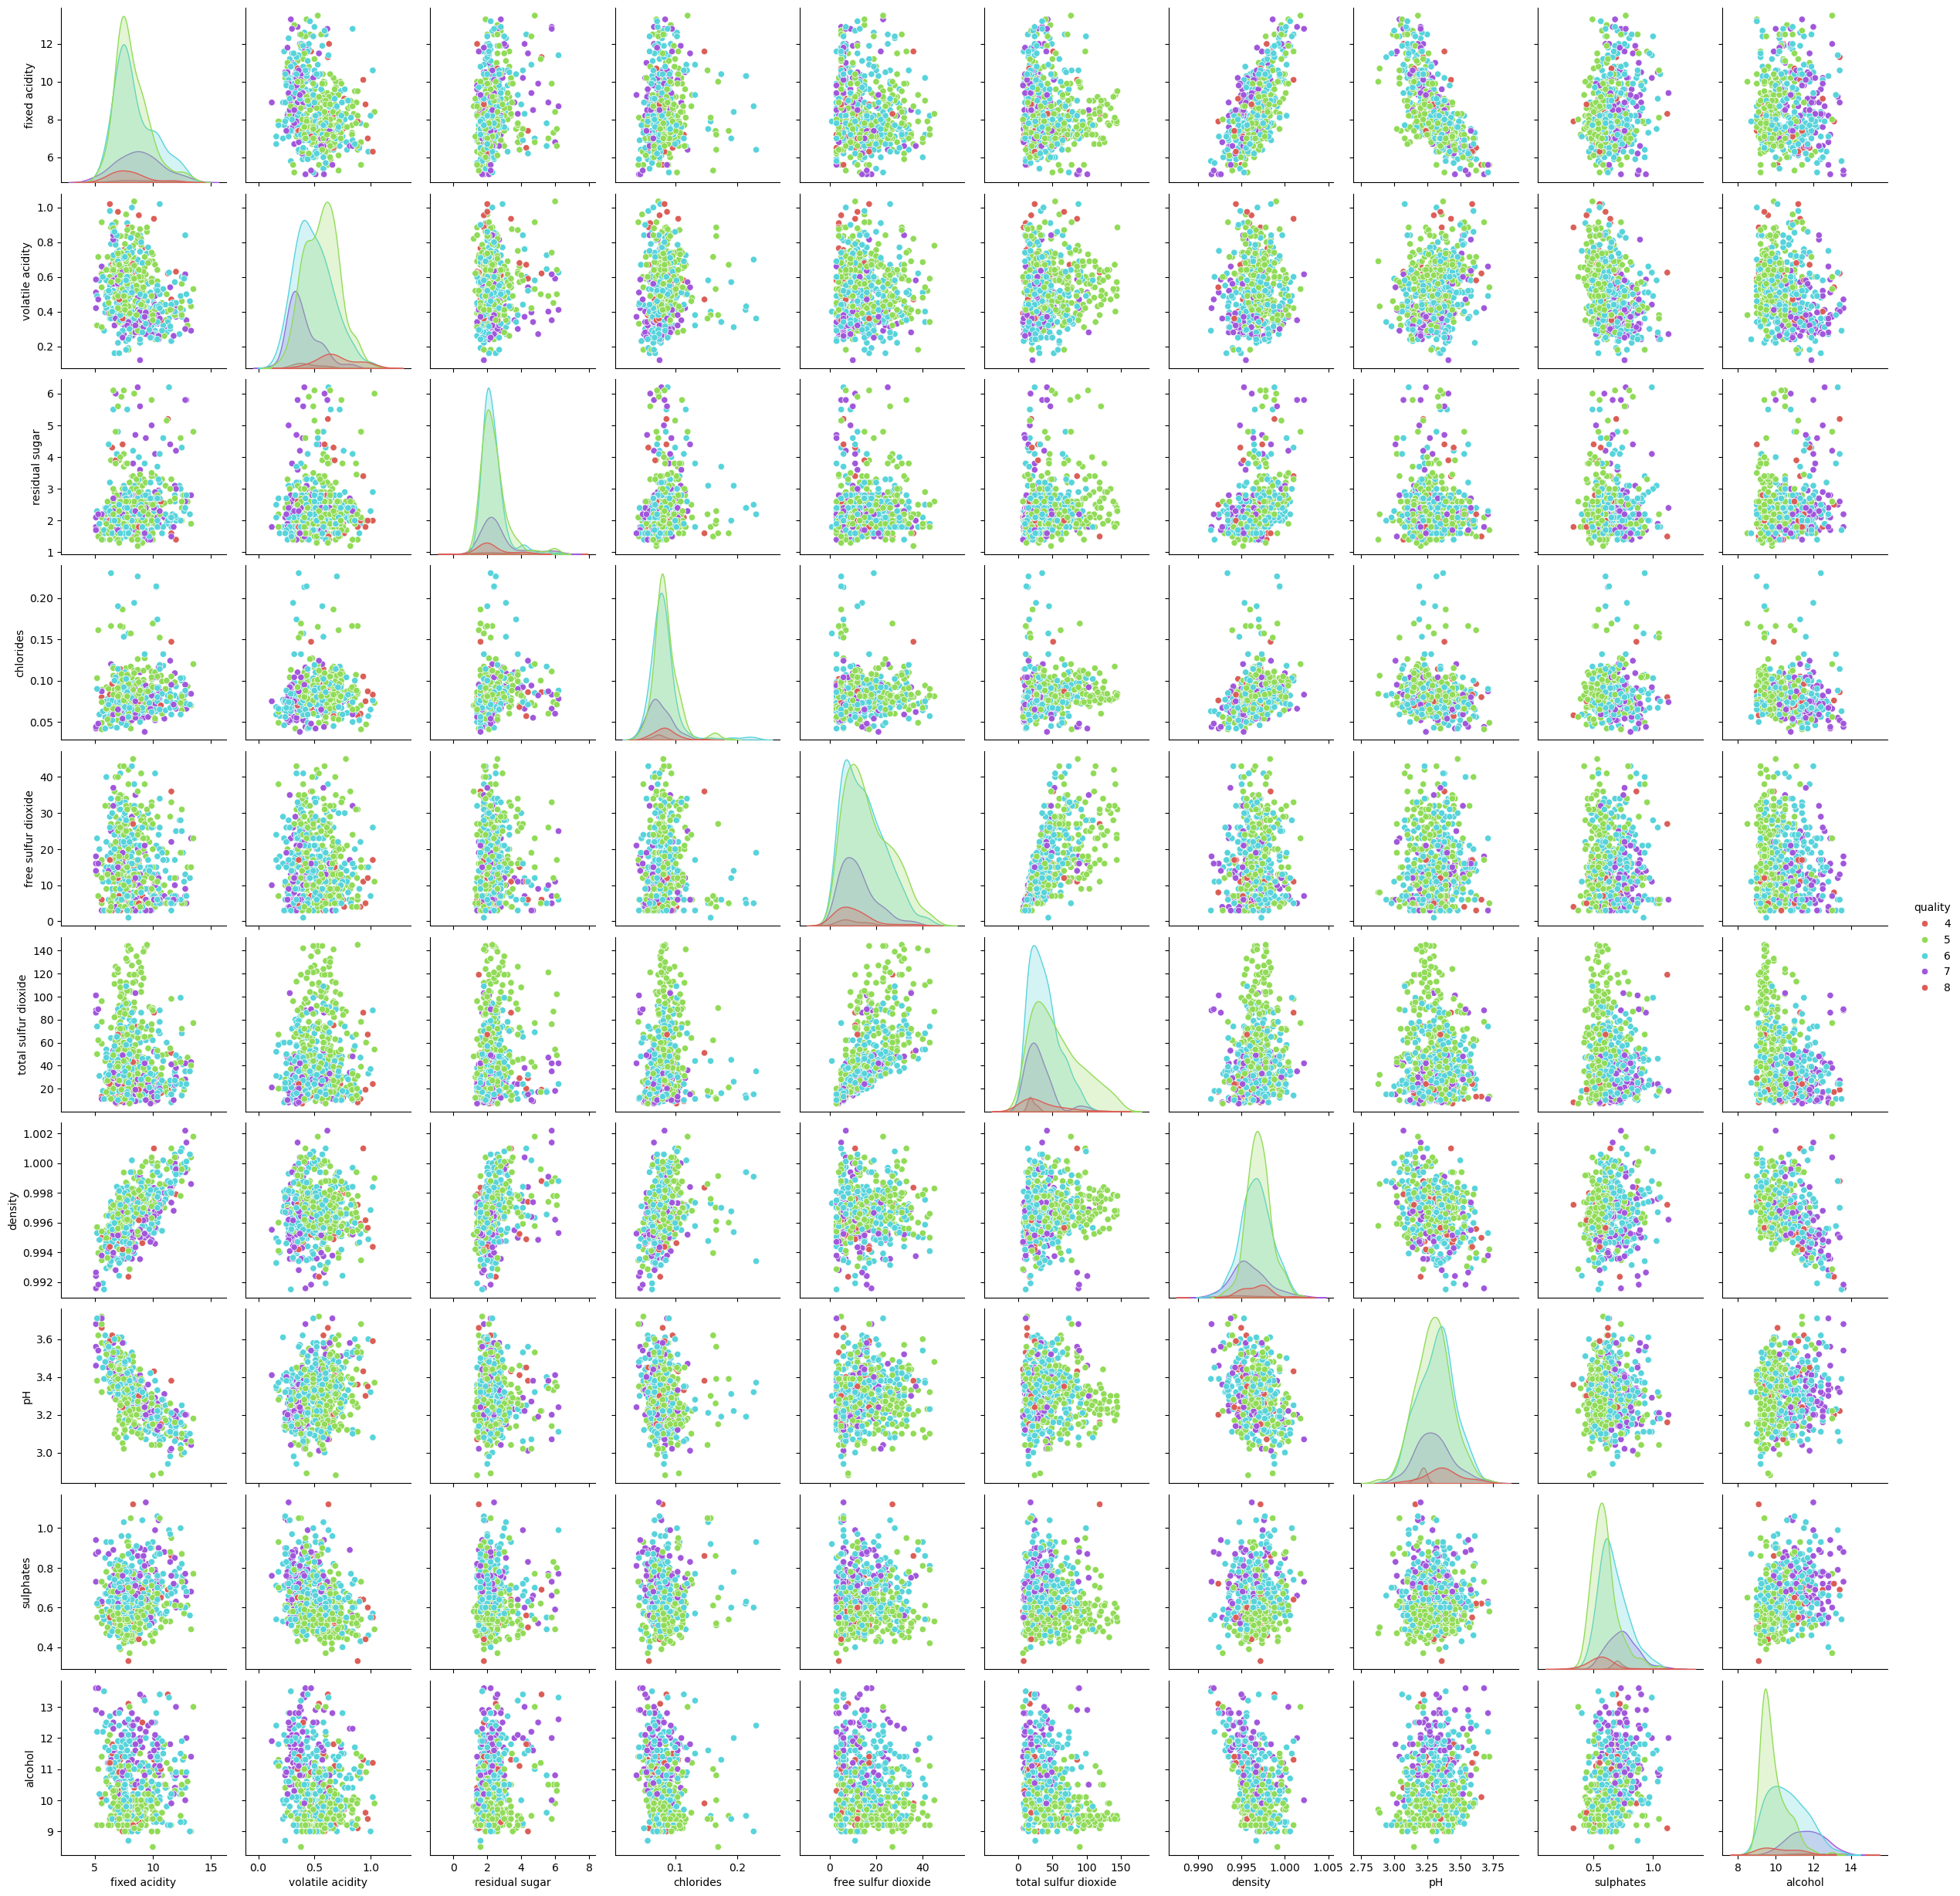

In [16]:
sns.pairplot(train_data_clean, hue='quality', palette='hls')

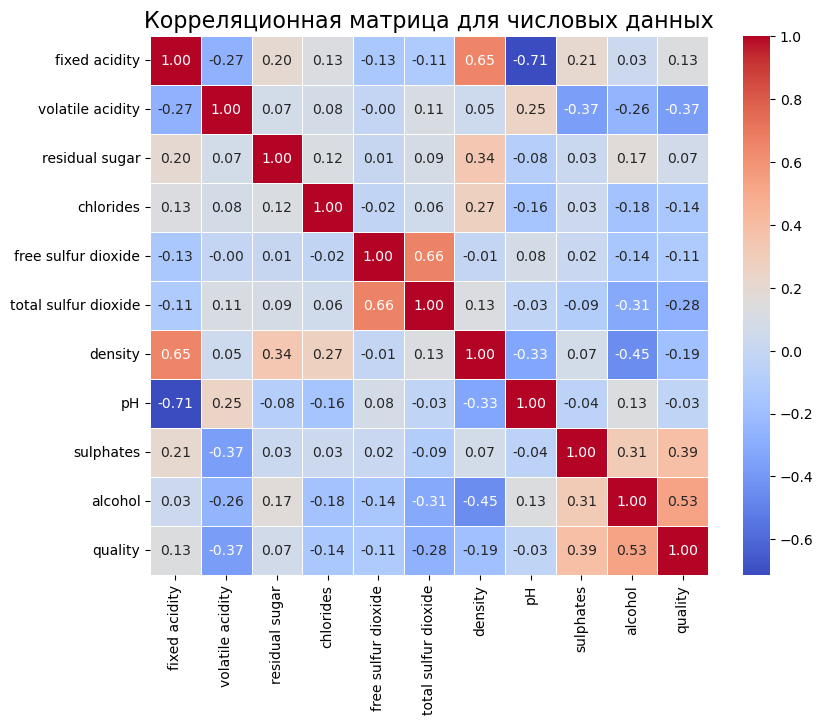

In [17]:
numeric_columns = train_data_clean.select_dtypes(include=['float64', 'uint64', 'int64'])
correlation_matrix = numeric_columns.corr(method = 'pearson')
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица для числовых данных', fontsize=16)
plt.show()

In [18]:
train_data_clean.reset_index(inplace=True, drop=True)
train_data_clean.shape

(641, 11)

In [19]:
target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
features_train = train_data_clean.drop(axis=1, columns=['quality'])
features_test = test_data.drop(axis=1, columns=['quality', 'citric acid'])
# .drop(axis=1, columns=['quality', 'citric acid'])
display(features_train.head(3))
display(features_test.isna().any())
display(target_test.shape)

fixed acidity  volatile acidity  residual sugar  chlorides  \
0            7.4              0.36             2.6      0.087   
1           11.9              0.57             2.6      0.082   
2            7.8              0.91             1.9      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 26.0                  72.0  0.99645  3.39       0.68   
1                  6.0                  32.0  1.00060  3.12       0.78   
2                 22.0                  47.0  0.99525  3.51       0.43   

   alcohol  
0     11.0  
1     10.7  
2     10.7

fixed acidity           False
volatile acidity        False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
dtype: bool

(305, 1)

In [20]:
#Решение с ипользованием kneighborsregressor
cv = ShuffleSplit(n_splits=5, random_state=10)
pipe_kneighbors = Pipeline([('preprocessing', StandardScaler()), ('classifier', KNeighborsClassifier())])

n_neighbors=[1, 3, 5, 9, 12, 15, 20, 25, 30, 35, 40]
p=[2, 3, 4, 6, 8]
weights=['uniform','distance']

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()],
     'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p,
     'classifier__weights': weights
     }
]

grid = GridSearchCV(pipe_kneighbors, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring='precision')
grid.fit(features_train, target_train.values.ravel())

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': KNeighborsClassifier(), 'classifier__n_neighbors': 5, 'classifier__p': 3, 'classifier__weights': 'distance', 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.627222



69   \
mean_fit_time                                                           0.015286   
std_fit_time                                                            0.002226   
mean_score_time                                                         0.057298   
std_score_time                                                          0.010424   
param_classifier                                          KNeighborsClassifier()   
param_classifier__n_neighbors                                                  5   
param_classifier__p                                                            3   
param_classifier__weights                                               distance   
param_preprocessing                                               MinMaxScaler()   
params                         {'classifier': KNeighborsClassifier(), 'classi...   
split0_test_score                                                       0.444444   
split1_test_score                                                            0.4   
split2_test_score                                                            1.0   
split3_test_score                                                       0.666667   
split4_test_score                                                          0.625   
mean_test_score                                                         0.627222   
std_test_score                                                          0.212397   
rank_test_score                                                                1   
split0_train_score                                                           1.0   
split1_train_score                                                           1.0   
split2_train_score                                                           1.0   
split3_train_score                                                           1.0   
split4_train_score                                                           1.0   
mean_train_score                                                             1.0   
std_train_score                                                              0.0   

                                                                             60   \
mean_fit_time                                                           0.019094   
std_fit_time                                                            0.005308   
mean_score_time                                                         0.037873   
std_score_time                                                          0.003573   
param_classifier                                          KNeighborsClassifier()   
param_classifier__n_neighbors                                                  5   
param_classifier__p                                                            2   
param_classifier__weights                                                uniform   
param_preprocessing                                               MinMaxScaler()   
params                         {'classifier': KNeighborsClassifier(), 'classi...   
split0_test_score                                                            0.5   
split1_test_score                                                       0.333333   
split2_test_score                                                            1.0   
split3_test_score                                                       0.714286   
split4_test_score                                                       0.571429   
mean_test_score                                                          0.62381   
std_test_score                                                          0.224568   
rank_test_score                                                                2   
split0_train_score                                                      0.790323   
split1_train_score                                                      0.787879   
split2_train_score                                                      0.702703   
split3_train_score                          

In [21]:
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, grid.predict(features_test))))

Правильность для наилучшей модели на тестовом наборе: 0.482759



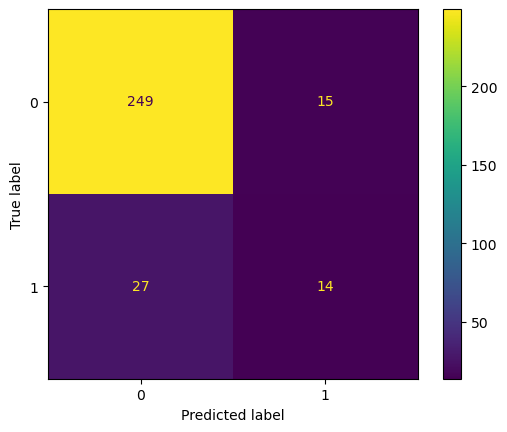

In [22]:
matrix = confusion_matrix(target_test, grid.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

In [23]:
features_test.shape

(305, 10)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Правильность модели на тестовом наборе: 0.636364



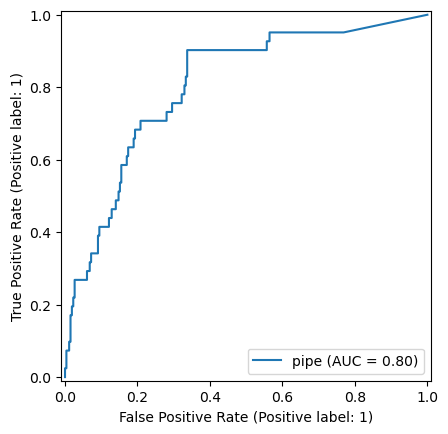

In [24]:
pipe_1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_jobs=-1, n_neighbors=30, p=4, weights='distance'))
pipe_1.fit(features_train,target_train)
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe');

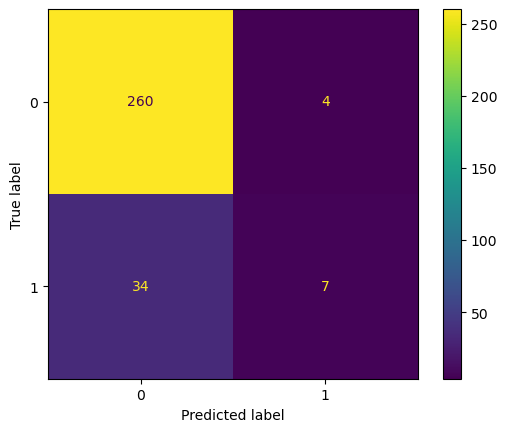

In [25]:
matrix = confusion_matrix(target_test, pipe_1.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

In [26]:
# def custom_predict(X, threshold):
#     probs = model.predict_proba(X) 
#     return (probs[:, 1] > threshold).astype(int)
    
    
# new_preds = custom_predict(X=X, threshold=0.4) 

Правильность модели на тестовом наборе: 0.636364

recall:  0.268  precision:, 0.407  thresholds:,0.407
recall:  0.171  precision:, 0.583  thresholds:,0.498


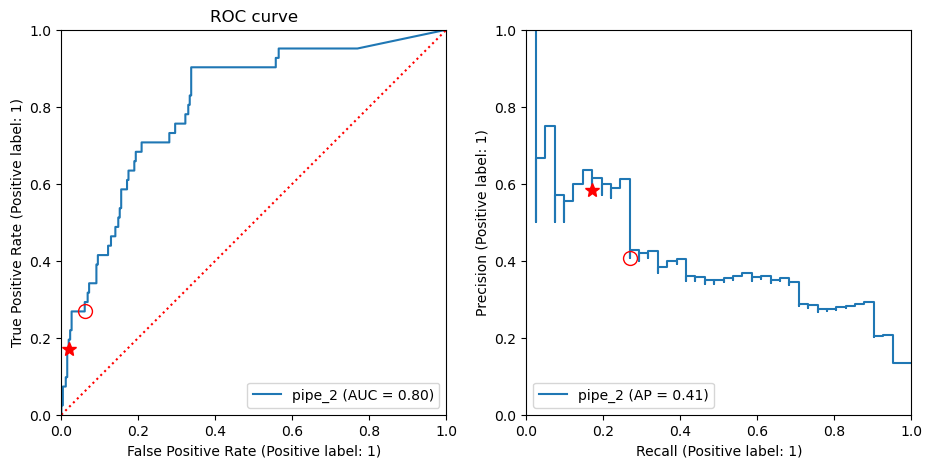

In [27]:
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 14
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [28]:
# решение с помощью SVC
cv = KFold(n_splits=7, random_state=1, shuffle=True)
pipe_svc = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

C=np.array([380, 450, 650, 1000])
gamma=[0.06, 0.07, 0.08, 0.09]
kernel=['rbf']

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
     'classifier': [svm.SVC()],
     'classifier__C': C,
     'classifier__gamma': gamma,
     'classifier__kernel': kernel
     }
]

grid = GridSearchCV(pipe_svc, param_grid, cv=cv, return_train_score=True, n_jobs=-1, scoring='precision')
grid.fit(features_train, target_train)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': SVC(), 'classifier__C': 650, 'classifier__gamma': 0.07, 'classifier__kernel': 'rbf', 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.584576



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


27  \
mean_fit_time                                                       0.06663   
std_fit_time                                                       0.002275   
mean_score_time                                                    0.043808   
std_score_time                                                     0.002106   
param_classifier                                                      SVC()   
param_classifier__C                                                     650   
param_classifier__gamma                                                0.07   
param_classifier__kernel                                                rbf   
param_preprocessing                                          MinMaxScaler()   
params                    {'classifier': SVC(), 'classifier__C': 650, 'c...   
split0_test_score                                                       0.5   
split1_test_score                                                     0.625   
split2_test_score                                                  0.555556   
split3_test_score                                                  0.714286   
split4_test_score                                                  0.444444   
split5_test_score                                                  0.714286   
split6_test_score                                                  0.538462   
mean_test_score                                                    0.584576   
std_test_score                                                     0.096394   
rank_test_score                                                           1   
split0_train_score                                                 0.711864   
split1_train_score                                                 0.744681   
split2_train_score                                                 0.820513   
split3_train_score                                                 0.696429   
split4_train_score                                                 0.765957   
split5_train_score                                                 0.723404   
split6_train_score                                                 0.705882   
mean_train_score                                                    0.73839   
std_train_score                                                    0.040159   

                                                                         21  \
mean_fit_time                                                      0.058744   
std_fit_time                                                       0.003909   
mean_score_time                                                    0.042856   
std_score_time                                                     0.008419   
param_classifier                                                      SVC()   
param_classifier__C                                                     450   
param_classifier__gamma                                                0.09   
param_classifier__kernel                                                rbf   
param_preprocessing                                          MinMaxScaler()   
params                    {'classifier': SVC(), 'classifier__C': 450, 'c...   
split0_test_score                                                       0.5   
split1_test_score                                                     0.625   
split2_test_score                                                       0.5   
split3_test_score                                                  0.714286   
split4_test_score                                                  0.444444   
split5_test_score                                                  0.714286   
split6_test_score                                                  0.571429   
mean_test_score                                                    0.581349   
std_test_score                                                     0.099518   
rank_test_score                                                           2   
split0_train_score                         

Правильность для наилучшей модели на тестовом наборе: 0.521739



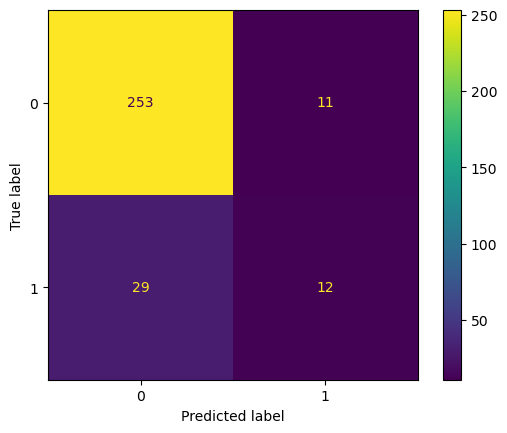

In [29]:
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, grid.predict(features_test))))
matrix = confusion_matrix(target_test, grid.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

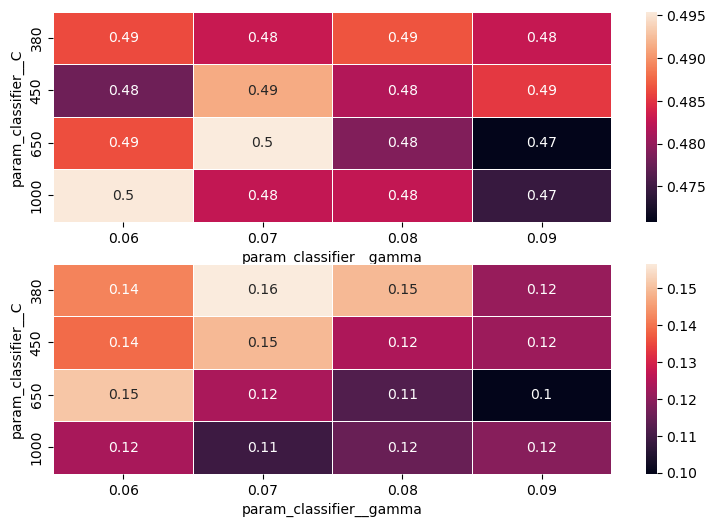

In [30]:
table=pd.DataFrame(grid.cv_results_)
pv_table=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='mean_test_score')
pv_table_std=table.pivot_table(index='param_classifier__C',columns='param_classifier__gamma',values='std_test_score')
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
sns.heatmap(pv_table, annot=True, linewidths=.5, ax=ax1);
sns.heatmap(pv_table_std, annot=True, linewidths=.5, ax=ax2);

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Правильность модели на тестовом наборе: 0.555556

recall:  0.293  precision:, 0.545  thresholds:,0.417
recall:  0.220  precision:, 0.562  thresholds:,0.532


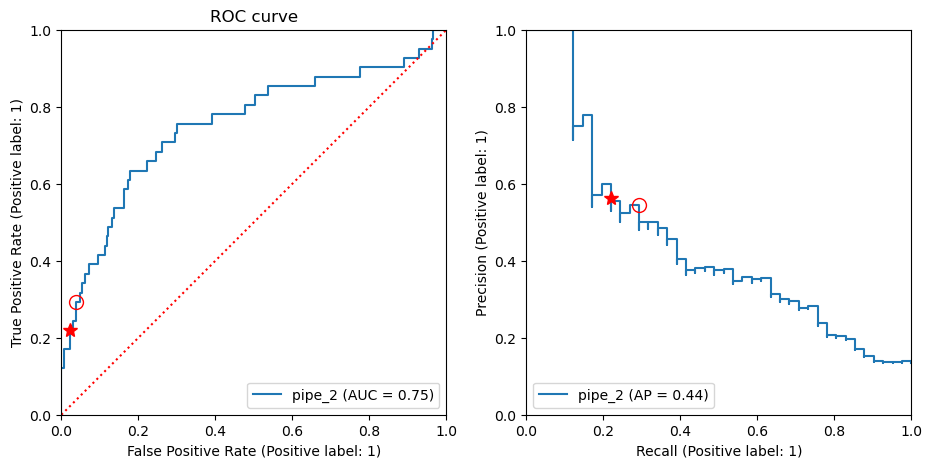

In [31]:
pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.06, C=380, probability=True, kernel='rbf'))
pipe_1.fit(features_train,target_train)
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 10
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [32]:
poly = PolynomialFeatures(degree=2, interaction_only=False)

In [33]:
list_pr=[]
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid'])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid'])
        features_train_poly = poly.fit_transform(features_train)
        features_test_poly = poly.fit_transform(features_test)
        pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
        pipe_1.fit(features_train_poly,target_train.values.ravel())
        list_pr.append(precision_score(target_test, pipe_1.predict(features_test_poly), zero_division=0))
print(f'Скор для полиномов...скор: {sum(list_pr)/10}')
print(features_test_poly.shape)

C:\Users\Arseny\AppData\Local\Temp\ipykernel_19788\1396074306.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


Скор для полиномов...скор: 0.5625521996768359
(305, 66)


In [34]:
list_preds=[]
col_names=['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
for j in col_names:
    list_preds=[]
    for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid', j])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', j])
        pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
        pipe_1.fit(features_train,target_train.values.ravel())
        list_preds.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
    print(f'Дроп строки {j} дополнительно...скор: {sum(list_preds)/10}')
    del list_preds

no_citr=[]
for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['quality']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid'])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid'])
        pipe_1 = make_pipeline(MinMaxScaler(), SVC(gamma=0.07, C=500, probability=True, kernel='rbf'))
        pipe_1.fit(features_train,target_train.values.ravel())
        no_citr.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
print(f'Дроп строки citric...скор: {sum(no_citr)/10}')

C:\Users\Arseny\AppData\Local\Temp\ipykernel_19788\363303148.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


Дроп строки fixed acidity дополнительно...скор: 0.7558356676003735
Дроп строки volatile acidity дополнительно...скор: 0.6518253968253969
Дроп строки residual sugar дополнительно...скор: 0.5935786435786435
Дроп строки chlorides дополнительно...скор: 0.6827665317139001
Дроп строки free sulfur dioxide дополнительно...скор: 0.5803787878787878
Дроп строки total sulfur dioxide дополнительно...скор: 0.592669413919414
Дроп строки density дополнительно...скор: 0.6325274725274725
Дроп строки pH дополнительно...скор: 0.7091183326477444
Дроп строки sulphates дополнительно...скор: 0.34657333705720805
Дроп строки alcohol дополнительно...скор: 0.4875
Дроп строки citric...скор: 0.6029793233082705


In [35]:
# решение с помощью LogReg
cv = KFold(n_splits=7, shuffle=True)
pipe_logreg = Pipeline([('preprocessing', StandardScaler()), ('classifier', LogisticRegression())])

penalty=['l2']
solver=['lbfgs']
C=np.array([0.1, 0.7, 0.8, 0.9, 1, 3, 5, 10])
max_iter=[100, 200, 300, 400, 500, 600, 700, 1000]


param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(), RobustScaler()], 
     'classifier': [LogisticRegression()],
     'classifier__C': C,
     'classifier__penalty': penalty,
     'classifier__solver': solver, 
     'classifier__max_iter': max_iter
     }
]

grid = GridSearchCV(pipe_logreg, param_grid, cv=cv, return_train_score=True, n_jobs=-2, scoring='precision', error_score="raise")
grid.fit(features_train, target_train)

print("----------------- Обучили и тестировали -------------------")
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Средняя правильность для наилучшей модели кроссвалидации на \
                валидационных тестовых наборах: {:.6f}\n".format(grid.best_score_)) 
gridresults = pd.DataFrame(grid.cv_results_)
display(gridresults.sort_values(["rank_test_score"]).T)

----------------- Обучили и тестировали -------------------
Наилучшие параметры:
{'classifier': LogisticRegression(), 'classifier__C': 1.0, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'preprocessing': MinMaxScaler()}

Средняя правильность для наилучшей модели кроссвалидации на                 валидационных тестовых наборах: 0.632653



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


102  \
mean_fit_time                                                         0.02963   
std_fit_time                                                         0.003098   
mean_score_time                                                      0.037998   
std_score_time                                                       0.005999   
param_classifier                                         LogisticRegression()   
param_classifier__C                                                       1.0   
param_classifier__max_iter                                                300   
param_classifier__penalty                                                  l2   
param_classifier__solver                                                lbfgs   
param_preprocessing                                            MinMaxScaler()   
params                      {'classifier': LogisticRegression(), 'classifi...   
split0_test_score                                                         1.0   
split1_test_score                                                         0.5   
split2_test_score                                                         1.0   
split3_test_score                                                    0.428571   
split4_test_score                                                         0.5   
split5_test_score                                                         1.0   
split6_test_score                                                         0.0   
mean_test_score                                                      0.632653   
std_test_score                                                        0.35495   
rank_test_score                                                             1   
split0_train_score                                                   0.454545   
split1_train_score                                                   0.166667   
split2_train_score                                                   0.461538   
split3_train_score                                                   0.714286   
split4_train_score                                                   0.538462   
split5_train_score                                                   0.461538   
split6_train_score                                                   0.454545   
mean_train_score                                                     0.464512   
std_train_score                                                      0.149658   

                                                                          117  \
mean_fit_time                                                        0.030479   
std_fit_time                                                         0.004789   
mean_score_time                                                      0.031741   
std_score_time                                                       0.002987   
param_classifier                                         LogisticRegression()   
param_classifier__C                                                       1.0   
param_classifier__max_iter                                               1000   
param_classifier__penalty                                                  l2   
param_classifier__solver                                                lbfgs   
param_preprocessing                                            MinMaxScaler()   
params                      {'classifier': LogisticRegression(), 'classifi...   
split0_test_score                                                         1.0   
split1_test_score                                                         0.5   
split2_test_score                                                         1.0   
split3_test_score                                                    0.428571   
split4_test_score                                                         0.5   
split5_test_score                                                         1.0   
split6_test_score                                                         0.0   
mean_test_score        

Правильность для наилучшей модели на тестовом наборе: 0.500000



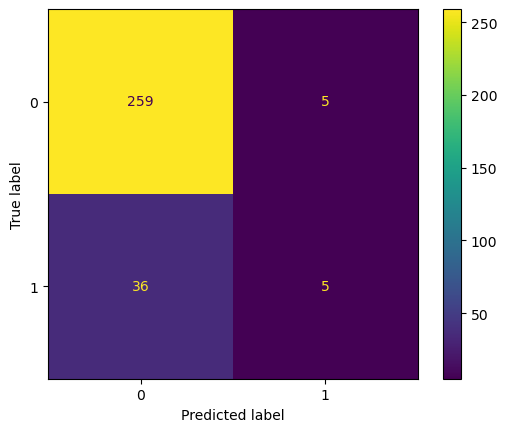

In [36]:
print("Правильность для наилучшей модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, grid.predict(features_test))))
matrix = confusion_matrix(target_test, grid.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Правильность модели на тестовом наборе: 0.500000

recall:  0.244  precision:, 0.588  thresholds:,0.411
recall:  0.122  precision:, 0.455  thresholds:,0.492


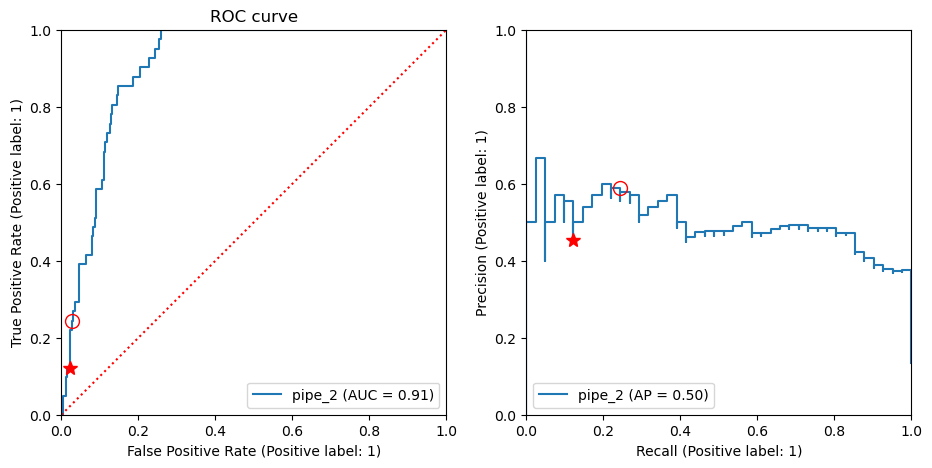

In [37]:
pipe_1 = make_pipeline(MinMaxScaler(), LogisticRegression(penalty='l2', C=0.9, solver='liblinear', max_iter=100))
pipe_1.fit(features_train,target_train)
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 10
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [38]:
list_preds=[]
col_names=['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
for j in col_names:
    list_preds=[]
    for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid', 'alcohol', 'total sulfur dioxide', j])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', 'alcohol', 'total sulfur dioxide', j])
        pipe_1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=31, p=2, weights='distance', n_jobs=-1))
        pipe_1.fit(features_train,target_train.values.ravel())
        list_preds.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
    print(f'Дроп строки {j} дополнительно...скор: {sum(list_preds)/10}')
    print(f'Стандартое отклонение {statistics.stdev(list_preds)}')
    del list_preds

no_citr=[]
for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid', 'alcohol', 'total sulfur dioxide'])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', 'alcohol', 'total sulfur dioxide'])
        pipe_1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=30, p=4, weights='distance', n_jobs=-1))
        pipe_1.fit(features_train,target_train.values.ravel())
        no_citr.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
print(f'Дроп строки citric, alcohol, total sulfur dioxide...скор: {sum(no_citr)/10}')
print(f'Стандартое отклонение {statistics.stdev(no_citr)}')

C:\Users\Arseny\AppData\Local\Temp\ipykernel_19788\3085109521.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


Дроп строки fixed acidity дополнительно...скор: 0.683015873015873
Стандартое отклонение 0.16653536862344745
Дроп строки volatile acidity дополнительно...скор: 0.5666666666666667
Стандартое отклонение 0.34426518632954817
Дроп строки residual sugar дополнительно...скор: 0.6808104395604395
Стандартое отклонение 0.13389864825092324
Дроп строки chlorides дополнительно...скор: 0.7433333333333333
Стандартое отклонение 0.18973665961010278
Дроп строки free sulfur dioxide дополнительно...скор: 0.7384848484848485
Стандартое отклонение 0.16386699844640548
Дроп строки density дополнительно...скор: 0.5790079365079366
Стандартое отклонение 0.24736520999352832
Дроп строки pH дополнительно...скор: 0.7223321123321124
Стандартое отклонение 0.16359928464289233
Дроп строки sulphates дополнительно...скор: 0.6818414918414919
Стандартое отклонение 0.1698295559186424
Дроп строки alcohol дополнительно...скор: 0.7132967032967034
Стандартое отклонение 0.23425596878732663
Дроп строки citric, alcohol, total sulfur 

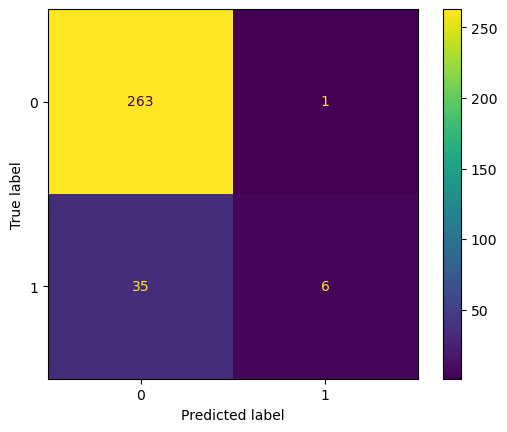

In [39]:
matrix = confusion_matrix(target_test, pipe_1.predict(features_test))
ConfusionMatrixDisplay(matrix).plot()

Правильность модели на тестовом наборе: 0.857143

recall:  0.293  precision:, 0.667  thresholds:,0.428
recall:  0.146  precision:, 0.857  thresholds:,0.501


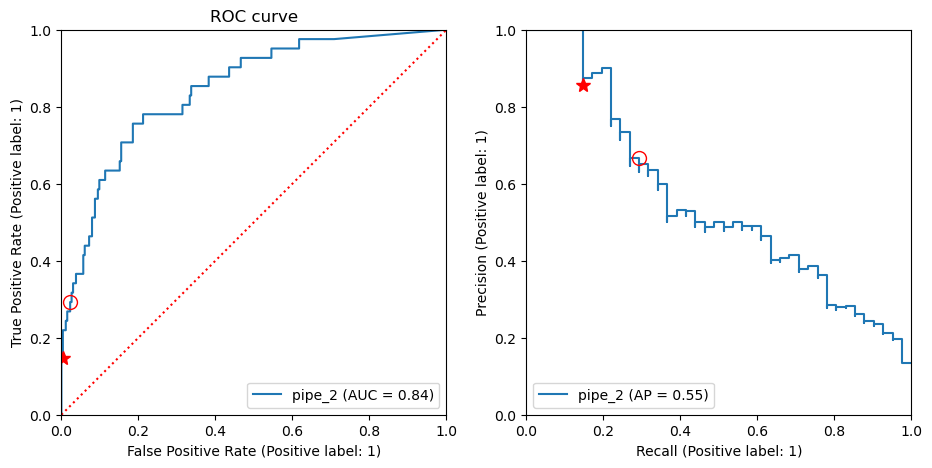

In [40]:
print("Правильность модели на тестовом наборе: {:.6f}\n".format(precision_score(target_test, pipe_1.predict(features_test))))


def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx
fpr, tpr, thresholds = roc_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
pos = 10
point = find_nearest(thresholds,0.5)
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(11, 5))
RocCurveDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax1)
ax1.set_title("ROC curve")
ax1.plot([0,1],[0,1], color="r", ls=":")
ax1.plot(fpr[point],tpr[point], '*', markersize=10, color="r")
ax1.plot(fpr[pos],tpr[pos], 'o', markersize=10,  mfc='none', color="r");
ax1.set_xlim((0, 1))
ax1.set_ylim((0, 1))
precision, recall, thresholds_pr = precision_recall_curve(target_test, pipe_1.predict_proba(features_test)[:,1], pos_label = None)
PrecisionRecallDisplay.from_estimator(pipe_1, features_test, target_test, name = 'pipe_2', ax=ax2)
point_pr = find_nearest(thresholds_pr,0.5)
pos_pr = find_nearest(thresholds_pr,thresholds[pos])
ax2.plot(recall[point_pr],precision[point_pr], '*', markersize=10, color="r")
ax2.plot(recall[pos_pr],precision[pos_pr], 'o', markersize=10,  mfc='none', color="r");
ax2.set_xlim((0, 1))
ax2.set_ylim((0, 1))
print( f'recall:  {recall[pos_pr]:.3f}', f' precision:, {precision[pos_pr]:.3f}', f' thresholds:,{thresholds[pos]:.3f}')
print( f'recall:  {recall[point_pr]:.3f}', f' precision:, {precision[point_pr]:.3f}', f' thresholds:,{thresholds[point]:.3f}')

In [41]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

In [42]:
print('Полиномы с дропом')
list_preds=[]
col_names=['fixed acidity', 'volatile acidity', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
path_train = 'train.csv'
data = pd.read_csv(path_train)
data_no_na = data.dropna(axis=0, subset=['fixed acidity', 'volatile acidity', 'pH', 'sulphates'])
only_na = data[~data.index.isin(data_no_na.index)]
data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)
no_duplicates = data_no_na.drop_duplicates(keep='first')
only_duplicates = data_no_na[~data_no_na.index.isin(no_duplicates.index)]
for j in col_names:
    list_preds=[]
    for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid', 'alcohol', 'total sulfur dioxide', j])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', 'alcohol', 'total sulfur dioxide', j])
        pipe_1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=31, p=2, weights='distance', n_jobs=-1))
        pipe_1.fit(features_train,target_train.values.ravel())
        list_preds.append(precision_score(target_test, pipe_1.predict(features_test), zero_division=0))
    print(f'Дроп строки {j} дополнительно...скор: {sum(list_preds)/10}')
    print(f'Стандартое отклонение {statistics.stdev(list_preds)}')
    del list_preds

no_citr=[]
for i in range(10):
        train_data, test_data, train_target, target_test = train_test_split(no_duplicates.drop(axis=1, columns=['wine_class']), pd.DataFrame(no_duplicates.wine_class), test_size=0.3,
                                                                        stratify=pd.DataFrame(no_duplicates['wine_class']), shuffle=True)
        z = stats.zscore(train_data)
        train_data_clean = train_data.drop(axis=1, columns=['citric acid', 'alcohol', 'total sulfur dioxide'])#[~(np.abs(z) > 3).any(axis=1)]
        train_data_clean.reset_index(inplace=True, drop=True)
        target_train = pd.DataFrame(train_data_clean['quality'].apply(lambda x: 0 if x < 7 else 1))
        features_train = train_data_clean.drop(axis=1, columns=['quality'])
        features_test = test_data.drop(axis=1, columns=['quality', 'citric acid', 'alcohol', 'total sulfur dioxide'])
        features_train_poly = poly.fit_transform(features_train)
        features_test_poly = poly.fit_transform(features_test)
        pipe_1 = make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=30, p=4, weights='distance', n_jobs=-1))
        pipe_1.fit(features_train_poly,target_train.values.ravel())
        no_citr.append(precision_score(target_test, pipe_1.predict(features_test_poly), zero_division=0))
print(f'Дроп строки citric, alcohol, total sulfur dioxide...скор: {sum(no_citr)/10}')
print(f'Стандартое отклонение {statistics.stdev(no_citr)}')

Полиномы с дропом


C:\Users\Arseny\AppData\Local\Temp\ipykernel_19788\3932868739.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_na['wine_class'] = data_no_na['quality'].apply(lambda x: 0 if x < 7 else 1)


Дроп строки fixed acidity дополнительно...скор: 0.7856565656565657
Стандартое отклонение 0.15027008074449072
Дроп строки volatile acidity дополнительно...скор: 0.6966666666666667
Стандартое отклонение 0.24416650865877837
Дроп строки residual sugar дополнительно...скор: 0.5736813186813187
Стандартое отклонение 0.18222346027758335
Дроп строки chlorides дополнительно...скор: 0.7796428571428571
Стандартое отклонение 0.17306360379912217
Дроп строки free sulfur dioxide дополнительно...скор: 0.6500308025308024
Стандартое отклонение 0.17914709880487595
Дроп строки density дополнительно...скор: 0.6511904761904762
Стандартое отклонение 0.21207338276526036
Дроп строки pH дополнительно...скор: 0.6717460317460316
Стандартое отклонение 0.19347224833540164
Дроп строки sulphates дополнительно...скор: 0.6127380952380952
Стандартое отклонение 0.25161556668068363
Дроп строки alcohol дополнительно...скор: 0.8389285714285715
Стандартое отклонение 0.12547974202577936
Дроп строки citric, alcohol, total sulfu